## Multimodal embedding with CLIP



Reference - https://huggingface.co/learn/cookbook/en/faiss_with_hf_datasets_and_clip


In [4]:
!pip install -q datasets faiss-cpu transformers sentencepiece


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 74.7 MB/s eta 0:00:00


In [5]:
import torch
from PIL import Image
from transformers import AutoImageProcessor, AutoModel, AutoTokenizer
import faiss
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

print(device)

model = AutoModel.from_pretrained("openai/clip-vit-base-patch16").to(device)
processor = AutoImageProcessor.from_pretrained("openai/clip-vit-base-patch16")
tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch16")

cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/599M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [6]:
from datasets import load_dataset

ds = load_dataset("jmhessel/newyorker_caption_contest", "explanation")

README.md: 0.00B [00:00, ?B/s]

explanation/train-00000-of-00001.parquet:   0%|          | 0.00/125M [00:00<?, ?B/s]

explanation/validation-00000-of-00001.pa(…):   0%|          | 0.00/7.97M [00:00<?, ?B/s]

explanation/test-00000-of-00001.parquet:   0%|          | 0.00/6.80M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2340 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/130 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/131 [00:00<?, ? examples/s]

Dataset - https://huggingface.co/datasets/jmhessel/newyorker_caption_contest

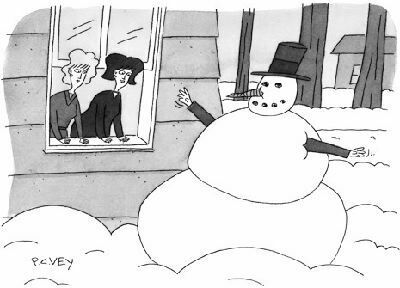

In [7]:
ds["train"][0]["image"]


In [8]:
ds["train"][0]["image_description"]


'Two women are looking out a window. There is snow outside, and there is a snowman with human arms.'

## Embed the descriptions

In [9]:
dataset = ds["train"]
ds_with_embeddings = dataset.map(lambda example:
                                {'embeddings': model.get_text_features(
                                    **tokenizer([example["image_description"]],
                                                truncation=True, return_tensors="pt")
                                    .to("cuda"))[0].detach().cpu().numpy()})

Map:   0%|          | 0/2340 [00:00<?, ? examples/s]

In [12]:
for i in range(5):
    print(ds_with_embeddings[i]['embeddings'])

[0.21113300323486328, 0.41771426796913147, -0.2493201494216919, -0.05857594311237335, 0.15120962262153625, 0.19114559888839722, -0.09114894270896912, 0.31428828835487366, 0.3844295144081116, -0.06496298313140869, 0.01108456403017044, 0.10785046219825745, 0.06453193724155426, 0.5791853666305542, 0.397052139043808, 0.16040514409542084, -0.2291666567325592, -0.12549741566181183, -0.21285012364387512, -0.30483654141426086, -0.27440154552459717, 0.2171005755662918, -0.3250514268875122, 0.04044868052005768, 0.20940491557121277, 0.07987652719020844, 0.11839232593774796, -0.324787974357605, -0.16067545115947723, 0.0656314343214035, 0.3317292034626007, 0.07531695067882538, 0.2244872748851776, -0.06748213618993759, 0.04464845731854439, 0.2359921634197235, 0.15442699193954468, 0.15918102860450745, -0.014310777187347412, -0.43417370319366455, 0.1072898581624031, 0.11760580539703369, -0.03700616955757141, 0.046513140201568604, -0.21057018637657166, 0.17467263340950012, 0.17624351382255554, 0.121524

In [18]:
print(len(ds_with_embeddings[0]['embeddings']))

512


## Embed the images

In [19]:
ds_with_embeddings = ds_with_embeddings.map(lambda example:
                                          {'image_embeddings': model.get_image_features(
                                              **processor([example["image"]], return_tensors="pt")
                                              .to("cuda"))[0].detach().cpu().numpy()})

Map:   0%|          | 0/2340 [00:00<?, ? examples/s]

In [20]:
for i in range(5):
    print(ds_with_embeddings[i]['image_embeddings'])

[0.5684421062469482, 0.07431340962648392, -0.5868570804595947, 0.3606078624725342, 0.2138739675283432, -0.03902202844619751, -0.4252404570579529, -0.05898468196392059, -0.08561067283153534, 0.2934282720088959, -0.14487631618976593, 0.018566012382507324, 0.31325003504753113, 0.5080890655517578, 0.2738039791584015, 0.4651351571083069, 0.006563037633895874, 0.27480143308639526, -0.011209152638912201, 0.08049052953720093, -0.28350630402565, -0.036035045981407166, -0.08075380325317383, -0.27118057012557983, -0.10163509845733643, -0.3345518112182617, 0.04223852977156639, 0.035219646990299225, 0.3041909337043762, 0.15629889070987701, 0.21077415347099304, -0.08138830959796906, -0.21043534576892853, -0.3511674404144287, -0.45910030603408813, -0.11612328886985779, -0.15426668524742126, -0.34686511754989624, -0.14188846945762634, 1.6001495122909546, -0.14781656861305237, -0.14639246463775635, -0.2317577302455902, 0.2670828700065613, -0.36442944407463074, 0.07023842632770538, -0.3645719587802887, 

In [21]:
print(len(ds_with_embeddings[0]['image_embeddings']))

512


## Create an index for each column

In [22]:
# create FAISS index for text embeddings
ds_with_embeddings.add_faiss_index(column='embeddings')

  0%|          | 0/3 [00:00<?, ?it/s]

Dataset({
    features: ['image', 'contest_number', 'image_location', 'image_description', 'image_uncanny_description', 'entities', 'questions', 'caption_choices', 'from_description', 'label', 'n_tokens_label', 'instance_id', 'embeddings', 'image_embeddings'],
    num_rows: 2340
})

In [23]:
# create FAISS index for image embeddings
ds_with_embeddings.add_faiss_index(column='image_embeddings')

  0%|          | 0/3 [00:00<?, ?it/s]

Dataset({
    features: ['image', 'contest_number', 'image_location', 'image_description', 'image_uncanny_description', 'entities', 'questions', 'caption_choices', 'from_description', 'label', 'n_tokens_label', 'instance_id', 'embeddings', 'image_embeddings'],
    num_rows: 2340
})

## Querying the data with text prompts

In [24]:
prmt = "a snowy day"
prmt_embedding = model.get_text_features(**tokenizer([prmt], return_tensors="pt", truncation=True).to("cuda"))[0].detach().cpu().numpy()
scores, retrieved_examples = ds_with_embeddings.get_nearest_examples('embeddings', prmt_embedding, k=1)

['A man is in the snow. A boy with a huge snow shovel is there too. They are outside a house.']


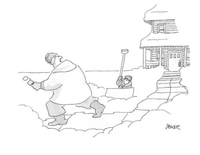

In [25]:
def downscale_images(image):
  width = 200
  ratio = (width / float(image.size[0]))
  height = int((float(image.size[1]) * float(ratio)))
  img = image.resize((width, height), Image.Resampling.LANCZOS)
  return img

images = [downscale_images(image) for image in retrieved_examples["image"]]
# see the closest text and image
print(retrieved_examples["image_description"])
display(images[0])

## Querying the data with image prompts


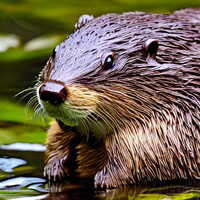

In [36]:
import requests
# image of a beaver
url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/beaver.png"
image = Image.open(requests.get(url, stream=True).raw)
display(downscale_images(image))

In [49]:
img_embedding = model.get_image_features(**processor([image], return_tensors="pt", truncation=True).to("cuda"))[0].detach().cpu().numpy()
scores, retrieved_examples = ds_with_embeddings.get_nearest_examples('image_embeddings', img_embedding, k=1)

Unused or unrecognized kwargs: truncation.


['Salmon swim upstream but they see a grizzly bear and are in shock. The bear has a smug look on his face when he sees the salmon.']


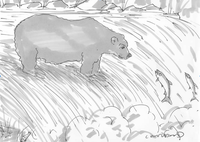

In [50]:
images = [downscale_images(image) for image in retrieved_examples["image"]]
# see the closest text and image
print(retrieved_examples["image_description"])
display(images[0])